# PHASE I
---

### Importing libraries

In [24]:
%matplotlib inline
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


### Inputing and Displaying dataset

In [25]:
testImagesLinks = ['https://i.cbc.ca/1.4580539.1521235681!/fileImage/httpImage/image.png_gen/derivatives/16x9_780/sudoku-guy-robin-jarman.png',
                   'https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg',
                   'https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg',
                   'https://d3i71xaburhd42.cloudfront.net/424014dcf1ea3e6f4dc46d59eeb2be3b34c75f0e/1-Figure1-1.png',
                   'https://a1.mzstatic.com/us/r30/Purple5/v4/50/bd/d8/50bdd8c9-1403-2c9d-40d9-9c9bd4dc7905/screen1136x1136.jpeg',
                   'https://suresolv.com/sites/default/files/u2/Expert-Sudoku-hard-level-5-game-12.png',
                   'https://github.com/H-a-m-za/Sudoko/blob/main/CV%20dataset/img1.jpg?raw=true',
                   'https://user-images.githubusercontent.com/72568092/121086105-088e9e00-c7e3-11eb-9189-6b7cba0dc2d3.jpg',
                   'https://content.instructables.com/F43/P59G/ACZEPD7QXFF/F43P59GACZEPD7QXFF.jpg?auto=webp&frame=1&fit=bounds&md=f0a7c1a7e4222e1a5f670d66ecf5dc04',
                   'https://drive.google.com/file/d/1FQtcEW1OGAPy0fyUOJOcsnHFVO3ekqx7/view?usp=drive_link'
                   ]
testImagesNames = ["",
                   "01-Normal.jpg",   #done
                   "02-TheMightyFinger.jpg",  #done
                   "03-WhereBorder.jpg", #NO
                   "04-CompressoEspresso.jpg",  #done
                   "05-Ya3amSheel2elCoinYa3am.jpg",  #done
                   "06-FarAndCurved.jpg",  #done
                   "07-2elNoor2ata3.jpg",  #done
                   "08-MeshShayef7agaYa3am.jpg",  #done
                   "09-Normal2.jpg",  #done
                   "10-Mal7wFelfel.jpg",  #done
                   "11-FlashBang.jpg",  #done
                   "12-BrokenPrinter.jpg",  #done
                   "13-DarkMode.jpg",  #done
                   "14-Sine.jpg",  #done
                   "15-GoneWithTheWind.jpg", #No
                   "16-SomethingWentTerriblyWrongHere.jpg" #No

]

#link = testImagesLinks[12]
#req = urllib.request.urlopen(link)

arr = cv2.imread("CV dataset/" + testImagesNames[9])
img = np.asarray(arr, dtype=np.uint8)
#img = cv2.imdecode(arr2, cv2.IMREAD_COLOR) # 'Load it as it is'
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Displaying RGB image

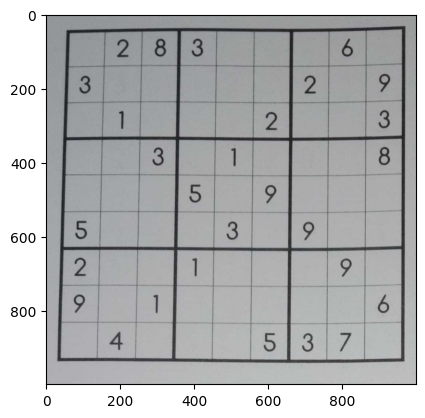

In [26]:
plt.imshow(img_rgb)

### Convert image to gray-scale

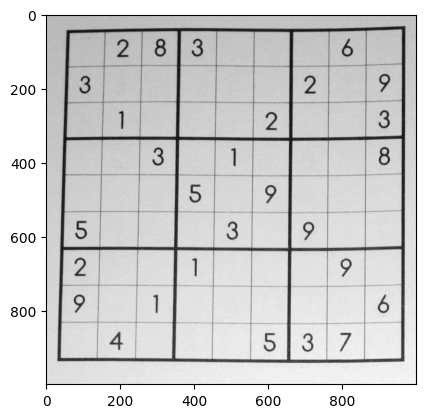

In [27]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray")


# **PREPROCESSING THE IMAGE**



---



### Equalize Histogram and apply gamma correction (If Picture is too dark)

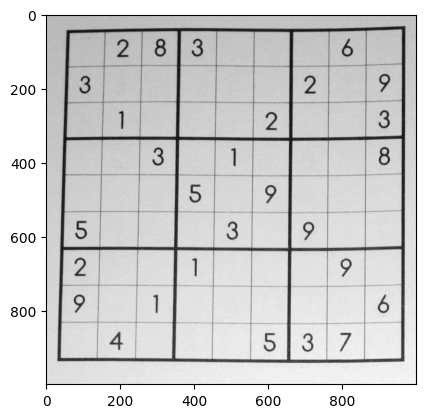

In [28]:
def gamma_correct(image,gamma):

#Create a mapping table for gamma correction
  gamma_table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(0, 256)]).astype(np.uint8)

#Apply gamma correction using the mapping table
  corrected_image = cv2.LUT(image, gamma_table)

  return corrected_image



#If image is too dark
if np.amax(img_gray) < 100:
    img_gray = cv2.equalizeHist(img_gray)
    img_gray = gamma_correct(img_gray,15)

plt.imshow(img_gray,cmap = "gray")

## Noise Removal Techniques

### Min Filter Implementation

In [29]:
def minFilter(image,kernel):
  padded = np.pad(image, pad_width=1, mode="constant",constant_values = (0,0))
  result = np.zeros((padded.shape[0],padded.shape[1]))
  for i in range(0, padded.shape[0] - kernel + 1):
      for j in range(0, padded.shape[1] - kernel + 1):
          window = padded[i:i+kernel, j:j+kernel]
          result[i, j] = np.min(window)
  return result[1:padded.shape[0]-1, 1:padded.shape[1]-1]

### We tried Min Filter (which has proven not to work well)




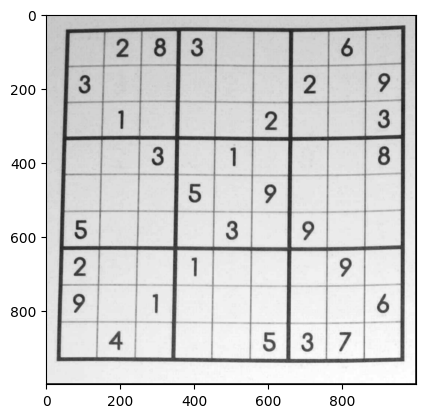

In [30]:
min_filtered = minFilter(img_gray,3)
plt.imshow(min_filtered,cmap = "gray")

### We tried Applying Gaussian filter (Which also added no value)


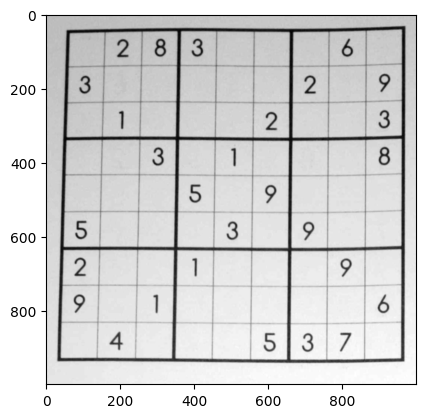

In [31]:
image_blur = cv2.GaussianBlur(img_gray,(5,5),0)
image_blur = np.asarray(image_blur, dtype=np.uint8)
plt.imshow(image_blur,cmap = "gray")

### We Apply Median Filter to the image

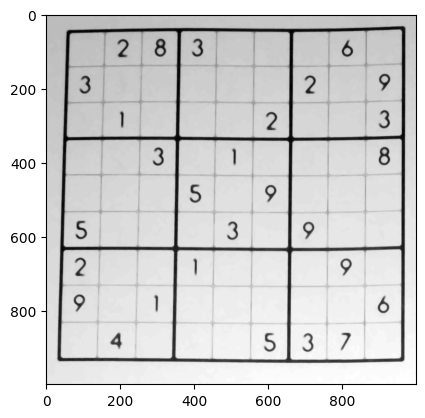

In [32]:
median_filtered = img_gray
for i in range(7):
  median_filtered = cv2.medianBlur(median_filtered,5)
plt.imshow(median_filtered,cmap = "gray")

### Invert the image if image is dark mode

In [33]:
img_hist , _ = np.histogram(median_filtered, bins=256)
if np.argmax(img_hist) < 127 and np.amax(median_filtered) > 240:
   median_filtered = 255 - median_filtered


## Thresholding Methods:

---

### Let's try normal thresholding (which has proven to be a failure)

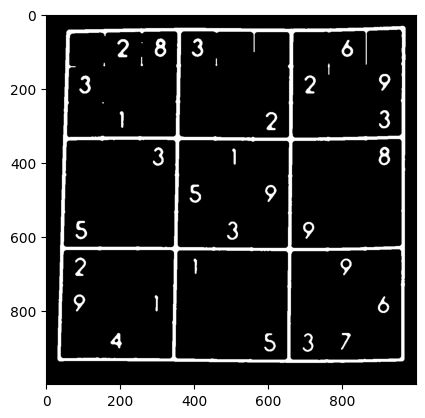

In [34]:
img_global_threshold = cv2.threshold(median_filtered,
                                     127,
                                     255,
                                     cv2.THRESH_BINARY_INV)[1] #Apparently threshold function returns three things, The second item is the image
plt.imshow(img_global_threshold, cmap = "gray")

### Adaptive Thresholding has proven to be better

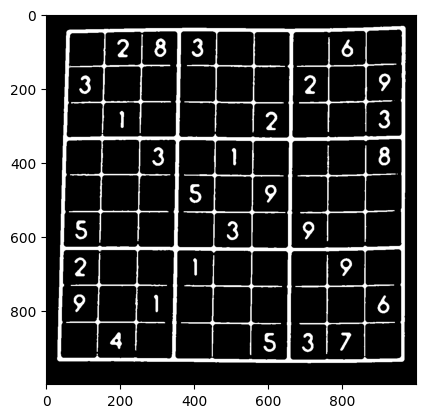

In [35]:
img_gray_threshed = cv2.adaptiveThreshold(median_filtered,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=111,
    C=5
)
plt.imshow(img_gray_threshed, cmap="gray");

### Apply Dilation to enhance lines

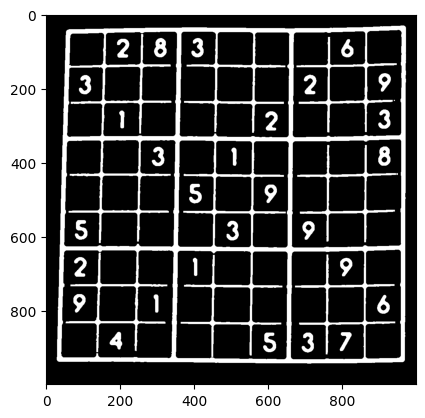

In [36]:
kernel = np.ones((3,3),np.uint8)
kernel2 = np.ones((3,3),np.uint8)
img_threshed_morphed = cv2.dilate(img_gray_threshed,kernel,iterations = 1)
#img_threshed_morphed = cv2.erode(img_threshed_morphed,kernel2,iterations = 1)
#img_threshed_morphed = img_gray_threshed
plt.imshow(img_threshed_morphed,cmap = "gray")

### Let's select our image for next phase, which is Edge Detection (Used For Testing)

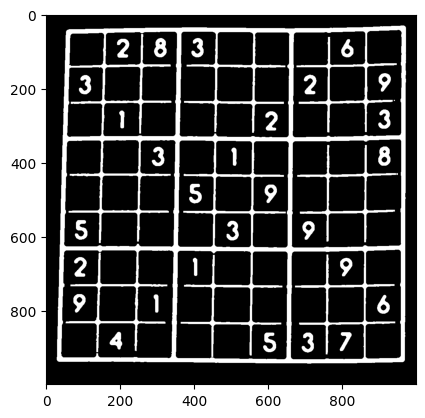

In [37]:
image_to_edges = img_threshed_morphed

plt.imshow(image_to_edges,cmap = "gray")

#  **Edge Detection**

### Apply Hough Transform For Edge Detection (high accuracy but edges are very thick which will become a problem in corner detection)

### Hough is applied first to focus on edges and get rid of numbers

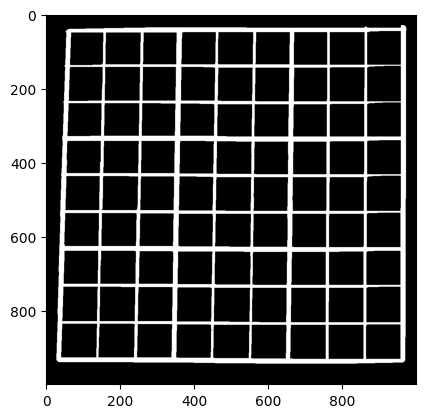

In [38]:
# Detect lines that are not smaller in length than:

minLineLength = min(image_to_edges.shape[0],image_to_edges.shape[1])/4

lines = cv2.HoughLinesP(
    image=image_to_edges,
    rho=1,
    theta=np.pi/180,
    threshold=200,
    minLineLength=minLineLength,
    maxLineGap = 45
)
#(x0,y0,x1,y1)
tmp_img = np.zeros_like(image_to_edges, dtype = np.uint8)
for x1, y1, x2, y2 in lines[:,0]: cv2.line(tmp_img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_img, cmap='gray');

### Apply Canny (resulting image is better suited for our purpose but the lines are too thin for accurate corner detection)

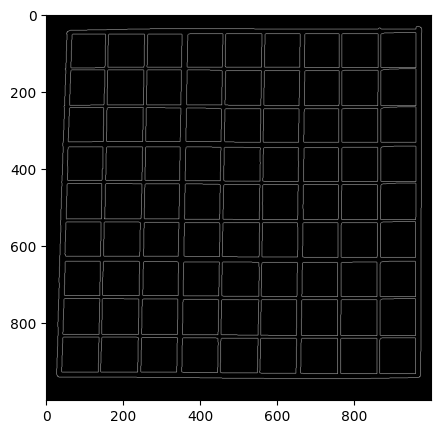

In [39]:
img_blurred = np.asarray(cv2.GaussianBlur(src=tmp_img, ksize=(3, 3), sigmaX=0),dtype = 'uint8')
img_canny_normal = cv2.Canny(image=tmp_img,
                      apertureSize=3,
                      threshold1=120,
                      threshold2=200,
                      L2gradient=True)
plt.figure(figsize=(7, 5))
plt.imshow(img_canny_normal, cmap="gray");

### Apply Morphological Operation to thicken the lines

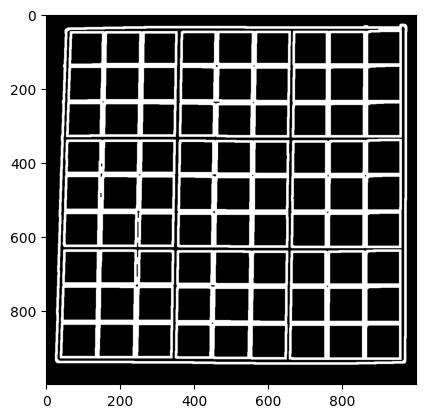

In [40]:
kernel = np.ones((5,5),np.uint8)
edges = cv2.dilate(img_canny_normal,kernel,iterations = 2)
kernel = np.ones((3,3),np.uint8)
img_canny = cv2.erode(edges,kernel,iterations = 1)
plt.imshow(img_canny,cmap = "gray")

### We Apply Hough again to get the lines

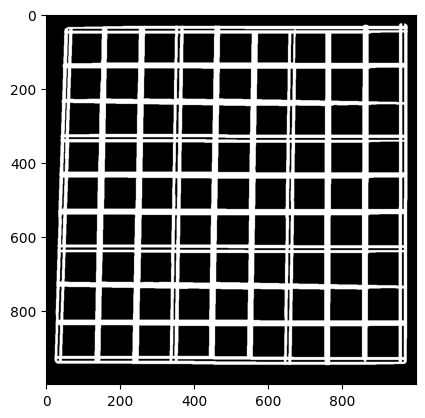

In [41]:
minLineLength = min(img_canny.shape[0],img_canny.shape[1])/3

lines = cv2.HoughLinesP(
    image=img_canny,
    rho=1,
    theta=np.pi/180,
    threshold=100,
    minLineLength=minLineLength,
    maxLineGap=50
)
#(x0,y0,x1,y1)
tmp_img = np.zeros_like(img_canny, dtype = np.uint8)
for x1, y1, x2, y2 in lines[:,0]: cv2.line(tmp_img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_img, cmap='gray');

### Now we select our edge detection method that will go to the next stage (Used for Testing)

In [42]:
choice = 0
if choice == 0:
  selected_lines = lines  #We Chose Pure Hough Transform
elif choice == 1:
  selected_lines = lines_Canny  #We Chose Hough Transform after Canny Transform



# **Here We get our intersection**
---

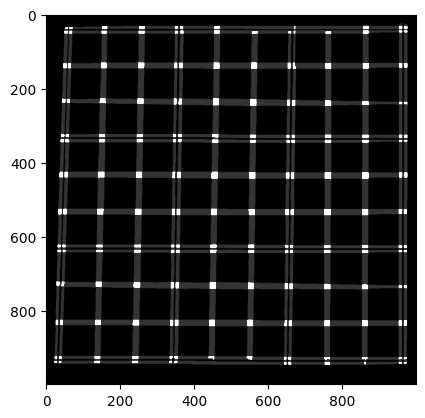

In [43]:
tmp_img2 = np.zeros_like(image_to_edges, dtype = np.uint16)

def angle_between_lines(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    delta_y1 = l1y2 - l1y1
    delta_x1 = l1x2 - l1x1
    a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
    a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
    return np.abs(a1 - a2)

def intersection_point(line1, line2):
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
    ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
    d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
    px = int(nx / d)
    py = int(ny / d)
    return (px, py)

def distance(pfrom, pto):
  return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)

#Line has to be in format (x1,y1,x2,y2)
def distance_line(line):
  return np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)

def slope_line(line):
  return (line[1] - line[3]) / (line[0] - line[2])

def point_on_line(point, line):
    diff = distance(point, line[0:2]) + distance(point, line[2:4]) - distance(line[0:2], line[2:4])
    return np.abs(diff) < 10

intersections = []
tmp_intersections = list()
line_num_of_intersections = 0
num_of_lines = len(selected_lines[:,0])
for i in range(num_of_lines):
    for j in range(i+1, num_of_lines):
        line1 = selected_lines[i,0]
        line2 = selected_lines[j,0]
        if (line1 is line2): continue
        a = angle_between_lines(line1, line2)
        if (a < 80 or a > 100): continue
        p = intersection_point(line1, line2)
        if point_on_line(p, line1) and point_on_line(p, line2):
            tmp_intersections.append(p[::-1])
            line_num_of_intersections += 1
    if line_num_of_intersections >= 8:
        for item in tmp_intersections:
              intersections.append(item)
              tmp_img2[item] = 5000
    tmp_intersections.clear()
    line_num_of_intersections = 0

plt.imshow(tmp_img2 + tmp_img, cmap="gray", vmin=0, vmax=1255);

# **Get OuterMost Points**

---

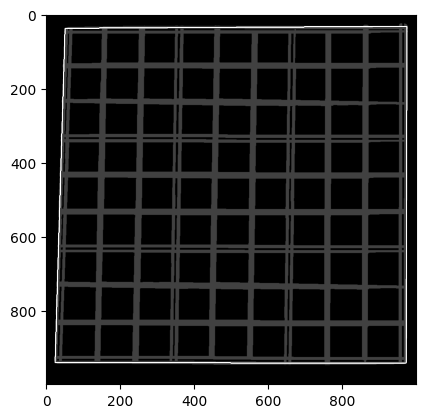

In [44]:
p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft
coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
tmp_img3 = np.zeros_like(img_gray_threshed, dtype = np.int32)
tmp_img3 = cv2.polylines(tmp_img3, coords, isClosed=True, color=(2550,0,0))
plt.imshow(tmp_img3 + tmp_img, cmap="gray", vmax=1000)





# **Warp The Image**

---

### We tried applying thinning to enhance final results

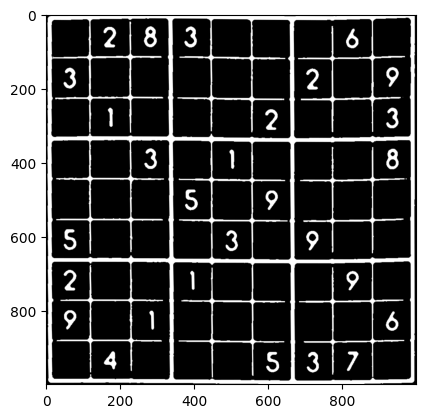

In [45]:
y, x = img_gray_threshed.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=img_gray_threshed,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=img_gray_threshed.shape[::-1]
)

plt.imshow(img_gray_threshed_warped, cmap="gray")




### Isolating Blocks of Sudoko Puzzle (now the image is preprocessed and ready for phase 2)

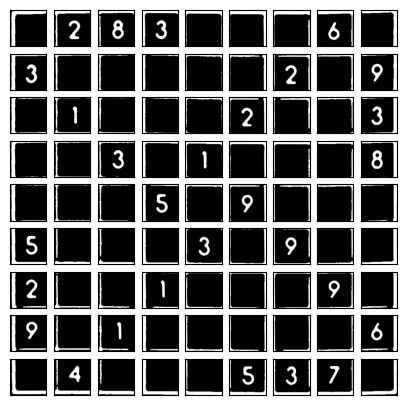

In [46]:
M = img_gray_threshed_warped.shape[0] // 9
N = img_gray_threshed_warped.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_gray_threshed_warped[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
